# Title: Implementing the Pairs Trading Strategy on Crypto Markets
Eshan Kaul

### Background
An emerging asset class, the recent surge of popularity in crypto markets has made cryptocurrencies an essential part of investment portfolios for retail and institutional investors. As prices for cryptocurrencies continue to break previous highs, the race is on for investors to develop a trading strategy that can take advantage of the high volatility and fluctuation that exists in the crypto markets. 
The pairs trading strategy is an example of a market-neutral strategy that attempts to take advantage of the mean reversion principle to eliminate inefficiencies between two highly correlated assets. In a market that is riddled with inefficiencies, the pairs trading strategy might be a highly effective and lucrative trading stagey for investors in crypto markets. 


In [47]:
import pandas as pd
import pandas_datareader as pdr
from statsmodels.tsa.stattools import coint
import requests
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import datetime as dt
import pandas_datareader as web
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import yfinance as yf
%matplotlib inline

### Read in Cryptocurrency Data 
The code below reads in the cryptocurrency price data from Yahoo Finance using the pandas_datareader and DateTime packages. Some minor data cleaning was required to prepare the dataset for analysis and visualization.

In [48]:
# yf.pdr_override()
start = dt.datetime(2018,1,1)
end = dt.datetime.now()
assets = ['BTC-USD', 'ETH-USD', 'USDT-USD', 'BNB-USD', 'USDC-USD', 'XRP-USD', 'SOL-USD', 'LUNA1-USD', 'DOGE-USD', 'SHIB-USD']

# CryptoDF = web.DataReader(assets , 'yahoo', start, end)
# CryptoDF = web.get_data_yahoo(assets, start, end)
CryptoDF = yf.download(assets, start, end)
print(CryptoDF)
CryptoDF = CryptoDF.dropna()

[*********************100%***********************]  10 of 10 completed
             Adj Close                                                  
               BNB-USD       BTC-USD  DOGE-USD      ETH-USD LUNA1-USD   
Date                                                                    
2018-01-01    8.414610  13657.200195  0.008909   772.640991       NaN  \
2018-01-02    8.837770  14982.099609  0.009145   884.443970       NaN   
2018-01-03    9.535880  15201.000000  0.009320   962.719971       NaN   
2018-01-04    9.213990  15599.200195  0.009644   980.921997       NaN   
2018-01-05   14.917200  17429.500000  0.012167   997.719971       NaN   
...                ...           ...       ...          ...       ...   
2023-05-11  307.695831  27000.789062  0.072085  1796.490601       NaN   
2023-05-12  308.603119  26804.990234  0.072459  1808.019775       NaN   
2023-05-13  311.086884  26784.078125  0.071777  1796.114868       NaN   
2023-05-14  312.135895  26930.638672  0.071986  1800.

In [49]:
cryptoDF = CryptoDF['Adj Close']
cryptoDF.reset_index(inplace=True)
crypto = px.line(cryptoDF, x = "Date", y = ['BTC-USD', 'ETH-USD', 'USDT-USD', 'BNB-USD', 'USDC-USD', 'XRP-USD', 'SOL-USD', 'LUNA1-USD', 'DOGE-USD', 'SHIB-USD'], title = "Cryptocurrencies Adj Close Time Series")
crypto.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
            dict(count = 1, label = "1m", step = "month", stepmode = "backward"),
            dict(count = 6, label = "6m", step = "month", stepmode = "backward"),
            dict(count = 1, label = "YTD", step = "year", stepmode = "todate"),
            dict(count = 1, label = "1y", step = "year", stepmode = "backward"),
            dict(step = "all")
        ])
    )
)
crypto.show()

As seen above it is often difficult to determine any relationships between different financial assets and cryptocurrencies using the adjusted closing prices. Instead of using prices, the log returns will be used to normalize the data such that all variables are in a comparable metric. This will enable the evaluation of analytic relationships of several cryptocurrencies despite them originating from price series of unequal values.

Assuming that the prices for the above cryptocurrencies are distributed log-normally or approximately log-normally, then the log return is likely normally distributed.

$$ r_t = log(1 + R_t) = log \frac {P_t}{P_{t−1}} = log(p_t) − log(p_{t−1})  $$

For further details see: https://quantivity.wordpress.com/2011/02/21/why-log-returns/

In [50]:
df = CryptoDF['Adj Close']
log_returns = np.log(df).diff()
log_returns = log_returns.dropna()
log_returns.reset_index(inplace=True)
log_returns.replace([np.inf, -np.inf], np.nan, inplace=True)
log_returns = log_returns.dropna()
log_returns.head()


/opt/homebrew/lib/python3.10/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning:

divide by zero encountered in log



,Date,BNB-USD,BTC-USD,DOGE-USD,ETH-USD,LUNA1-USD,SHIB-USD,SOL-USD,USDC-USD,USDT-USD,XRP-USD
1,2021-04-17,0.019788,-0.014543,-0.252695,-0.036451,-0.029507,0.693147,-0.011783,0.009409,0.009122,0.001622
2,2021-04-18,-0.078691,-0.076472,0.120221,-0.047044,-0.135276,0.000000,0.252295,-0.010346,-0.011360,-0.103974
3,2021-04-19,0.048804,-0.008789,0.239790,-0.032228,0.037210,0.693147,-0.019602,-0.000128,-0.000239,-0.066877
4,2021-04-20,0.150332,0.013348,-0.242837,0.072990,-0.034691,-0.693147,0.002968,0.000087,0.000073,0.050601
5,2021-04-21,-0.072412,-0.046520,-0.040154,0.014714,-0.011301,-0.693147,0.023117,0.000080,-0.000006,-0.064804


In [51]:
crypto = px.line(log_returns, x = "Date", y = ['BTC-USD', 'ETH-USD', 'USDT-USD', 'BNB-USD', 'USDC-USD', 'XRP-USD', 'SOL-USD', 'LUNA1-USD', 'DOGE-USD', 'SHIB-USD'], title = "Log Return Time Series")
crypto.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
            dict(count = 1, label = "1m", step = "month", stepmode = "backward"),
            dict(count = 6, label = "6m", step = "month", stepmode = "backward"),
            dict(count = 1, label = "YTD", step = "year", stepmode = "todate"),
            dict(count = 1, label = "1y", step = "year", stepmode = "backward"),
            dict(step = "all")
        ])
    )
)
crypto.show()

## Correlation VS Cointegration

Although correlation and cointegration are similar there are some key differences between the two that will be explored below. 

### Correlation
Definition: Any statistical relationship, whether causal or not, between two random variables or bivariate data. The Correlation Coefficient or Pearson correlation coefficient is commonly obtained by taking the ratio of the covariance of the two variables in question from the numerical dataset, normalized to the square root of their variances. Mathematically, it is the division of the covariance (joint variability of two random variables) of the two variables by the product of their standard deviations.

$$ \rho X,Y = \text{corr(X,Y)} = \frac{\text{cov}(X,Y)}{\sigma_x \sigma_y}  = \frac{E[(X-{\mu}x)(Y-{\mu}y)]}{\sigma_x \sigma_y}$$


$$ \text{cov}(X, Y) = E[(X - E[X])(Y - E[Y])]$$

For further details see: https://en.wikipedia.org/wiki/Correlation

### Cointegration
Definition: A test for non-stationary time series processes that have variances and means that vary over time. This method allows for estimating the long-run parameters or equilibrium in systems with unit root variables. If two or more series are individually integrated (in the time series sense) but some linear combination of them has a lower order of integration, then the series are said to be cointegrated.

In most cases when the individual series $Y_{1,t} \text{and} Y_{2,t}$ are non-stationary first-order integrated variables $I(1)$, a linear combination of these variables is also non-stationary. However, if there exists some (cointegrating) vector of coefficients that form a stationary linear combination of them it is said that the two series are cointegrated.

Consider the two series $Y_{1,t} \text{and} Y_{2,t}$ which are integrated of the first order, $I(1)$. Regressing these variables on one another creates the linear regression model: $u_t = Y_{1,t} - \beta_1Y_{2,t}$
If the error term $u_t$ is stationary, $I(0)$, then by definition the combined $Y_{1,t} - \beta_1Y_{2,t}$ must also be stationary. While both $Y_{1,t} \text{and} Y_{2,t}$ have distinct stochastic trends, the series $Y_{1,t} \text{and} Y_{2,t}$ are cointegrated as  the linear combination $Y_{1,t} - \beta_1Y_{2,t}$ has the statistical properties of an $I(0)$ series.

For further details see: https://hudsonthames.org/an-introduction-to-cointegration/

### Cointegration Tests

For further information on cointergration testing see: https://www.uh.edu/~bsorense/coint.pdf </be>

For further information on ADF test see: https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/


### Engle-Granger two-step method
The Engle-Granger is one of the most common tests used to measure cointegration. It constructs residual errors based on the statistic regress. The test checks the residuals for the presence of unit roots using an Augmented Dickey-Fuller test (ADF test). If the residuals are stationary the two-time series are said to be cointegrated. 

1. The first step of this method is to verify that the individual time series are non-stationary. This is done using the standard unit root test and ADF test. Both series must be non-stationary first-order integrated variables $I(1)$. Consider the two series $Y_{1,t} \text{and} Y_{2,t}$ which are integrated of the first order, $I(1)$. The following ECM model is estimated. ${\displaystyle A(L)\,\Delta y_{t}=\gamma +B(L)\,\Delta x_{t}+\alpha (y_{t-1}-\beta _{0}-\beta _{1}x_{t-1})+\nu _{t}.}$ If both variables are integrated and this ECM exists, they are cointegrated by the Engle–Granger representation theorem.
2. The second step of the Engle-Granger test is to estimate the model using the ordinary least squares (OLS) ${\displaystyle y_{t}=\beta _{0}+\beta _{1}x_{t}+\varepsilon _{t}}$. In the case the regression is not spurious as determined by the test criteria described the OLS will be valid and demonstrate a consistent estimator (converging in probability to the true value of the parameter). The estimated residuals ${\displaystyle {\hat {\varepsilon _{t}}}=y_{t}-\beta _{0}-\beta _{1}x_{t}}$ are saved and are used in a regression of differenced variables plus the lagged error term. ${\displaystyle A(L)\,\Delta y_{t}=\gamma +B(L)\,\Delta x_{t}+\alpha {\hat {\varepsilon }}_{t-1}+\nu _{t}.}$ From here the test for cointegration is completed using a standard t-statistic on $\alpha$. 
Where it follows that if ${\alpha}: \leq 0.05$  the two-time series are cointegrated.

This test will reject the null if the p-value < 0.05 in which case there is no need to find an order of differencing. If the p-value is > 0.05 then we would fail to reject the null and the series will require differencing operations to be performed until the time series is stationary. 


$\begin{eqnarray}
\Delta y_{1,t}&=& \gamma_{0} + \alpha_{1} \left[ y_{1,t-1}-\beta_1 y_{2,t-1} \right] + \ldots \sum_{i=1}^{K} \zeta_{1,i} \Delta y_{1,t-1} + \sum_{j=1}^{L} \zeta_{2,j} \Delta y_{2,t-1} + \varepsilon_{y_1,{t}} \\
\Delta y_{2,t} &=& \eta_{0} + \alpha_{2} \left[ y_{1,t-1}-\beta_1 y_{2,t-1} \right] + \ldots\sum_{i=1}^{K} \xi_{1,i} \Delta y_{2,t-1} + \sum_{j=1}^{L} \xi_{2,j} \Delta y_{1,t-1} + \varepsilon_{y_2,{t}}
\end{eqnarray}$

$\begin{eqnarray}
\Delta y_{1,t}&=& \gamma_{0} + \alpha_{1} \left[y_{1,t-1}-\beta_1 y_{2,t-1} \right]\end{eqnarray}$



#### Issues with the Engle-Granger Test 
1. The univariate unit root tests used in the first stage have low statistical power
2. The choice of the dependent variable in the first stage influences test results, i.e. we need weak exogeneity for $x_t$as determined by Granger causality
3. One can potentially have a small sample bias
4. The cointegration test on $\alpha$  does not follow a standard distribution
5. The validity of the long-run parameters in the first regression stage where one obtains the residuals cannot be verified because the distribution of the OLS estimator of the cointegrating vector is highly complicated and non-normal
6. At most one cointegrating relationship can be examined.

### Johansen Test
Many of the weaknesses of the Engle-Granger Test can be addressed by the Johansen Test which is a type of vector error correction model (VECM) that assesses the validity of cointegrating relationships using a maximum likelihood estimate (MLE) approach. The Johansen test seeks to test for cointegration in the multivariate case by determining the rank of $\Pi$ and determining the number of non-zero eigenvalues in $\Pi$. The Johansen Test proposes two methods for estimating the rank, one with the trace statistic and one with the maximum eigenvalue statistic. 

#### VAR
Consider a first order Vector Autoregression $VAR(1)$ for the $n\times1
$ vector $\boldsymbol{y}_{t}=[y_{1,t}, y_{2,t}, \ldots ,y_{n,t}]^{\prime}$ $$\begin{eqnarray}
\boldsymbol{y}_{t}=\mu+\Pi_{1} \boldsymbol{y}_{t-1}+\boldsymbol{u}_{t}
\end{eqnarray}$$
where $\mu=[\mu_{1} , \mu_{2}, \ldots ,\mu_{n}]^{\prime}$ is a vector of constants
$\boldsymbol{u}_{t}=[ u_{1,t},u_{2,t}, \ldots , u_{n,t}]^{\prime}$ is a vector of error terms
and $\Pi_{1}$ is a $(n \times n)$ matrix of coefficients
 
The stability of the VAR model is determined by the eigenvalues of $\Pi_{1}$ that are obtained by solving the characteristic equation $\begin{eqnarray}
| \; \Pi_{1}- I \; |=0
\end{eqnarray}$ where VAR is stable if all eigenvalues are modulus less than 1. 

Consider the example when $n = 2$. The bivariate VAR(1) is:
$$\begin{eqnarray*}
\left[
\begin{array}
[c]{c}%
y_{1,t}\\
y_{2,t}%
\end{array}
\right]  =\left[
\begin{array}
[c]{c}%
\mu_{1}\\
\mu_{2}%
\end{array}
\right]  +\left[
\begin{array}
[c]{cc}%
\pi_{1,1} & \pi_{1,2}\\
\pi_{2,1} & \pi_{2,2}
\end{array}
\right]  \left[
\begin{array}
[c]{c}%
y_{1,t-1}\\
y_{2,t-1}%
\end{array}
\right]  +\left[
\begin{array}
[c]{c}%
\varepsilon_{1,t}\\
\varepsilon_{2,t}%
\end{array}
\right]
\end{eqnarray*}
$$
If one or more of the eigenvalues has a modulus greater than or equal to 1 then the VAR is unstable and is nonstationary. Extending this concept to cointegration for multivariate VAR models requires the specification of the vector error correction model. 

#### VECM
Rewriting VAR(1) as a VECM by differencing the series yeilds: 
$$\begin{eqnarray} \nonumber
\Delta {\bf{y}}_{t}  & = & \mu+(\Pi_{1}-I){\bf{y}}_{t-1}+{\bf{u}}_{t} \\
& = & \mu+\Pi {\bf{y}}_{t-1}+{\bf{u}}_{t} \;\;\; \mathsf{where } \; \Pi=(\Pi_{1}-I)
\end{eqnarray}
$$ 

 
#### Hypotheses

With $n$ variables, the number of linear combinations of the variables in $\boldsymbol{y}_{t}$ that are stationary will provide the resulting number of cointegration vectors. 

1. $\Pi$ has full rank $n = r$ The VAR must be stable as there is no instability present in the system of equations. 
2. $\Pi$ has rank $1\leq r\leq n-1$ The number of linear combinations is smaller than the number of variables. Hence, some of the variables must be unstable and at least one combination of the variables is stable. The number of cointegrating vectors is given by $r$.
3. $\Pi$ has rank $r=0$ i.e. $\Pi = 0$ There is instability present and no combination of the variables is stable. The unstable VAR is unable to be cointegrated and should be estimated using the first differences. 


When $VAR(p)$ are cointegrated, then the VECM includes the long-run cointegration as well as the speed of adjustment parameters. $\Pi$ is then decomposed as $\begin{eqnarray*}
\Pi=\alpha\beta^{\prime}
 \end{eqnarray*}$ where $\alpha$ and $\beta$ are dimensions $n \times r$ $\beta$ is a matrix of cointegraion parameters, such that the linear combinations of $\beta^{\prime} {\bf{y}}_{t}$ are stationary. Each of the $r$ rows in $\beta^{\prime} {\bf{y}}_{t}$ is a cointegrated long-run relation inducing stability. $\alpha$ is a matrix that contains the speed of adjustmet parameters which accounts for the time it takes to move back to equilibrium.  

Considering the original bivariate case: 
$$\begin{eqnarray}
\left[\begin{array}{c}
\Delta y_{1,t}\\ \Delta y_{2,t}
\end{array}\right] =
\left[\begin{array}{c}
\mu_{1}\\ \mu_{2}
\end{array}\right] +
\left[\begin{array}{c}
\alpha_{1}\\ \alpha_{2}
\end{array}\right]
\Big[\beta_{1} \beta_{2}\Big] \left[\begin{array}{c}
y_{1,t-1}\\ y_{2,t-1}
\end{array} \right] +
\left[\begin{array}{c}
u_{1,t}\\ u_{2,t}
\end{array}\right]
\end{eqnarray}
$$

The cointegration relationship $\beta^{\prime} {\bf{y}}_{t}$ is given by:
$$\begin{eqnarray*}
\beta^{\prime}{\bf{y}}_{t}=\beta_{1}y_{1,t}+\beta_{2}y_{2,t}\sim I(0)
\end{eqnarray*}
$$

Generalizing $VAR(p)$:
$$\begin{eqnarray*}
\Delta {\bf{y}}_{t}=\mu+\alpha\beta {\bf{y}}_{t-1}+\Gamma_{1}\Delta {\bf{y}}_{t-1}+\Gamma_{2}\Delta {\bf{y}}_{t-2}+ \ldots 
+\Gamma_{p-1}\Delta {\bf{y}}_{t-p-1} +  {\bf{u}}_{t}
\end{eqnarray*}
$$
where $p$ is the number of lags of the vector of variables.





The trace statistic specifies the null of hypothesis of $r$ cointegration relations as:
$$\begin{eqnarray}
\lambda_{trace}=-T\sum_{i=r+1}^{n}\log(1-\hat{\lambda}_{i}) \;\;\; r=0,1,2, \ldots , n-1
\end{eqnarray}$$

Where the alternative hypothesis is that there are more than $r$ cointegration relationships. <be>

The maximum eigenvalue statistic for the null hypothesis of at most $r$ cointegration relations can be computed as:
    
$$\begin{eqnarray}
\lambda_{max}=-T\log(1-\hat{\lambda}_{r+1}) \;\;\; r=0,1,2,\ldots, n-1
\end{eqnarray}$$
    
Where the alternative hypothesis is that there are $r + 1$ cointegration relations.

### Correlation Without Cointegration
An example of two assets that have high levels of correlation but are diverging. 

Correlation: 0.9904159301792916
Augmented Engle-Granger two-step cointegration test p-value: 0.9619271547181899


Cointegration Johansen test Trace Statistic & Critical Values:
[19.02788459  6.13059236]
[[16.1619 18.3985 23.1485]
 [ 2.7055  3.8415  6.6349]]


Cointegration Johansen test Eigen Statistic & Critical Values:
[12.89729223  6.13059236]
[[15.0006 17.1481 21.7465]
 [ 2.7055  3.8415  6.6349]]


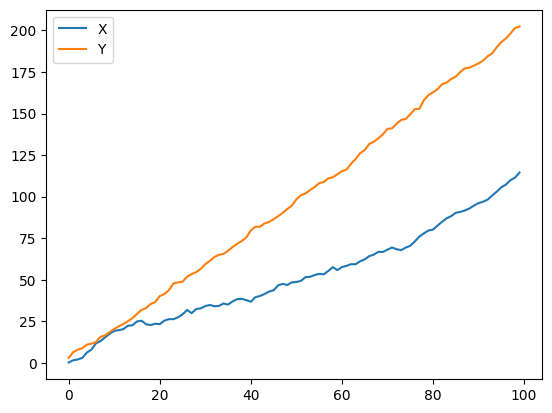

In [52]:
X_returns = np.random.normal(1, 1, 100)
Y_returns = np.random.normal(2, 1, 100)

X_diverging = pd.Series(np.cumsum(X_returns), name='X')
Y_diverging = pd.Series(np.cumsum(Y_returns), name='Y')

pd.concat([X_diverging, Y_diverging], axis=1).plot();

print('Correlation: ' + str(X_diverging.corr(Y_diverging)))
score, pvalue, _ = coint(X_diverging,Y_diverging)
print('Augmented Engle-Granger two-step cointegration test p-value: ' + str(pvalue))
print("\n")

df_diverging = pd.DataFrame({'x':X_diverging, 'y':Y_diverging})
jres = coint_johansen(df_diverging, 1, 0)

print('Cointegration Johansen test Trace Statistic & Critical Values:')
print(jres.trace_stat)
print(jres.trace_stat_crit_vals)
print("\n")
print('Cointegration Johansen test Eigen Statistic & Critical Values:')
print(jres.max_eig_stat)
print(jres.max_eig_stat_crit_vals)

### Cointegration Without Correlation
An example of two assets that have high levels of cointegration due to mean reversion as shown with a normally distributed series and square wave.

Correlation: -0.031571425625286934
Augmented Engle-Granger two-step cointegration test p-value: 0.0
Cointegration Johansen test Trace Statistic & Critical Values:
[696.3653904    9.31555294]
[[16.1619 18.3985 23.1485]
 [ 2.7055  3.8415  6.6349]]


Cointegration Johansen test Eigen Statistic & Critical Values:
[687.04983746   9.31555294]
[[15.0006 17.1481 21.7465]
 [ 2.7055  3.8415  6.6349]]


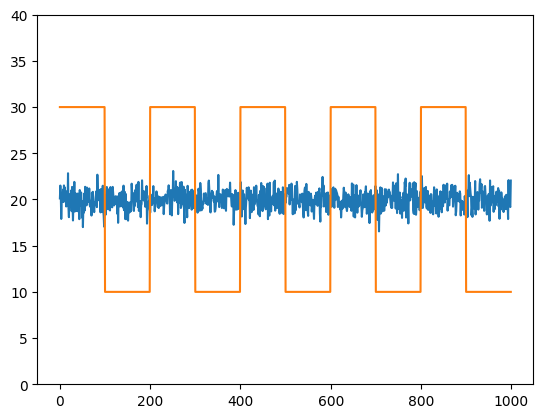

In [53]:
Y2 = pd.Series(np.random.normal(0, 1, 1000), name='Y2') + 20
Y3 = Y2.copy()
# Y2 = Y2 + 10
Y3[0:100] = 30
Y3[100:200] = 10
Y3[200:300] = 30
Y3[300:400] = 10
Y3[400:500] = 30
Y3[500:600] = 10
Y3[600:700] = 30
Y3[700:800] = 10
Y3[800:900] = 30
Y3[900:1000] = 10
Y2.plot()
Y3.plot()
plt.ylim([0, 40]);

# correlation is nearly zero
print('Correlation: ' + str(Y2.corr(Y3)))
score, pvalue, _ = coint(Y2,Y3)
print('Augmented Engle-Granger two-step cointegration test p-value: ' + str(pvalue))


df_coint = pd.DataFrame({'x':Y2, 'y':Y3})
jres = coint_johansen(df_coint, 1, 0)

print('Cointegration Johansen test Trace Statistic & Critical Values:')
print(jres.trace_stat)
print(jres.trace_stat_crit_vals)
print("\n")
print('Cointegration Johansen test Eigen Statistic & Critical Values:')
print(jres.max_eig_stat)
print(jres.max_eig_stat_crit_vals)

### High Correlation and Cointegration
An example of two assets that have high levels of cointegration and correlation with the long run expected value of spread between the two cointegrated time series converging around the mean. These example assets demonstrate a strong candidate for implementing a pairs trading strategy.

Correlation: 0.9775242986169125
Augmented Engle-Granger two-step cointegration test p-value: 9.570809635342107e-11
Cointegration Johansen test Trace Statistic & Critical Values:
[71.42341214  4.34927488]
[[16.1619 18.3985 23.1485]
 [ 2.7055  3.8415  6.6349]]


Cointegration Johansen test Eigen Statistic & Critical Values:
[67.07413725  4.34927488]
[[15.0006 17.1481 21.7465]
 [ 2.7055  3.8415  6.6349]]


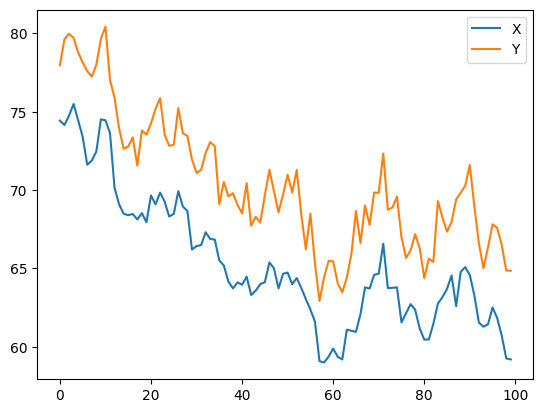

In [54]:
X_returns = np.random.normal(0, 1, 100) # Generates simulated daily returns
X = pd.Series(np.cumsum(X_returns), name='X') + 75
some_noise = np.random.normal(0, 1, 100)
Y = X + 5 + some_noise
Y.name = 'Y'
pd.concat([X, Y], axis=1).plot();
print('Correlation: ' + str(X.corr(Y)))
score, pvalue, _ = coint(X,Y)
print('Augmented Engle-Granger two-step cointegration test p-value: ' + str(pvalue))


df_coint = pd.DataFrame({'x':X, 'y':Y})
jres = coint_johansen(df_coint, 1, 0)

print('Cointegration Johansen test Trace Statistic & Critical Values:')
print(jres.trace_stat)
print(jres.trace_stat_crit_vals)
print("\n")
print('Cointegration Johansen test Eigen Statistic & Critical Values:')
print(jres.max_eig_stat)
print(jres.max_eig_stat_crit_vals)

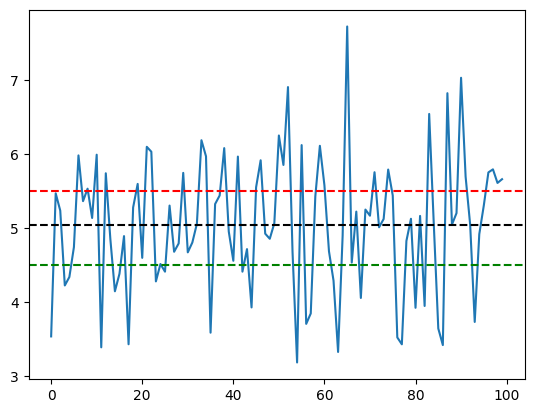

In [55]:
(Y-X).plot() # Plot the spread
plt.axhline((Y-X).mean(), color='black', linestyle='--') # Add the mean
plt.axhline(5.5, color='red', linestyle='--') 
plt.axhline(4.5, color='green', linestyle='--')

### Implementing the Pairs Trading Strategy

#### Hedging
Definition: An invesment position intended to offset and balance the potential risk of an investment by assuming a position in contary or opposing market or investment. 

For further details see: https://www.investopedia.com/trading/hedging-beginners-guide/

#### Short
Definition: Short selling is an investment or trading strategy that speculates on the decline in a stock or other security's price. Investors or portfolio managers may use short selling as a hedge against the risk of a long position in the same or a related security. The position is opened by borrowing shares of an asset that the investor belives will decrease in value. The investor sells the borrowed shares to buyers willing to pay the current market price and hopes that they will be able to repurchase the shares at a lower price before returning the borrowed shares. 
#### Long
Definition: A long position is an investment or trading strategy that speculates on the increase in a stock or other security's price. Investors or portfolio managers may use a long position as a hedge against the risk of a short position in the same or related security. An example of opening a long position is through the purchase of  a long call options contract which gives the holder the option to buy the underlying asset at a certain price. 

For further details see: https://www.investopedia.com/ask/answers/100314/whats-difference-between-long-and-short-position-market.asp

#### Pairs Trading
Securities with high conintegration and covariance tend to have an approximatly stationary distance or spread, although there will be periods when the distance between the two securities is high and periods when the distance is low. Pairs trading comes from maintaining a hedged position across X and Y. If both securities go down money is neither made nor lost, and likewise if both go up. The strategy for making a profitable investment relys on the spread of the two securities reverting to the mean. When the spread between securities X and Y are far apart the following positions will be opened: short Y and long X. Similarly when the spread between securities X and Y are close together the following positions will be opened: long Y and short X. Once the divergent spred reverts to the long run mean the positions are closed. 


Additional literature related to pairs trading: 

https://ieeexplore.ieee.org/document/9200323/keywords#keywords  

https://www.stat.berkeley.edu/~aldous/Research/Ugrad/Amy_Zhang.pdf

https://link.springer.com/article/10.1007/s00186-021-00751-z

Below is a heat map of the Pearson correlation on the returns and the log returns series. Both heat maps appear to show several crypto assects that have high levels of correlation.  

,Date,BNB-USD,BTC-USD,DOGE-USD,ETH-USD,LUNA1-USD,SHIB-USD,SOL-USD,USDC-USD,USDT-USD,XRP-USD
Date,1.000000,0.488283,0.087819,0.112252,0.374408,0.322051,0.495352,0.384266,-0.276599,-0.400852,0.060427
BNB-USD,0.488283,1.000000,0.785900,0.762932,0.928449,0.603336,0.693414,0.764118,-0.193410,-0.186980,0.830569
BTC-USD,0.087819,0.785900,1.000000,0.625522,0.832994,0.513734,0.481208,0.620112,-0.126682,-0.072277,0.794327
DOGE-USD,0.112252,0.762932,0.625522,1.000000,0.746488,0.280271,0.370248,0.467126,-0.115627,-0.084146,0.859461
ETH-USD,0.374408,0.928449,0.832994,0.746488,1.000000,0.695278,0.767663,0.872450,-0.239857,-0.140882,0.813242
LUNA1-USD,0.322051,0.603336,0.513734,0.280271,0.695278,1.000000,0.678595,0.721332,-0.208444,-0.036869,0.447803
SHIB-USD,0.495352,0.693414,0.481208,0.370248,0.767663,0.678595,1.000000,0.862615,-0.233977,-0.126089,0.429712
SOL-USD,0.384266,0.764118,0.620112,0.467126,0.872450,0.721332,0.862615,1.000000,-0.214078,-0.106497,0.595938
USDC-USD,-0.276599,-0.193410,-0.126682,-0.115627,-0.239857,-0.208444,-0.233977,-0.214078,1.000000,0.616191,-0.090556
USDT-USD,-0.400852,-0.186980,-0.072277,-0.084146,-0.140882,-0.036869,-0.126089,-0.106497,0.616191,1.000000,-0.023141


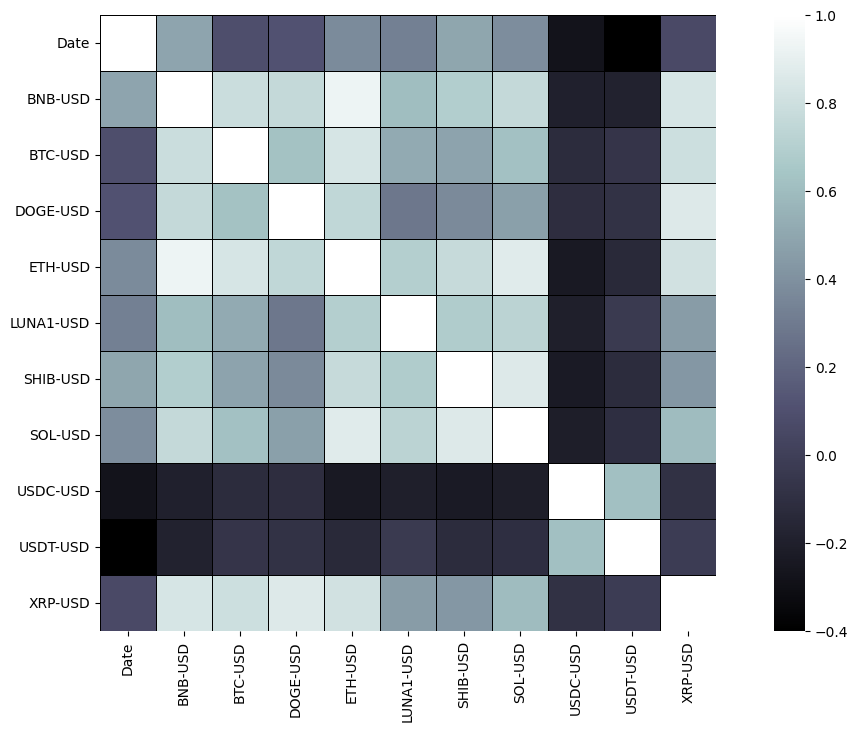

In [56]:
plt.figure(figsize = (15,8))
sns.heatmap(cryptoDF.corr(), cmap = "bone", linewidths = .7, linecolor = "black", square = True)
cryptoDF.corr()

,Date,BNB-USD,BTC-USD,DOGE-USD,ETH-USD,LUNA1-USD,SHIB-USD,SOL-USD,USDC-USD,USDT-USD,XRP-USD
Date,1.000000,-0.000254,-0.010543,-0.001488,-0.042837,-0.051025,-0.064000,-0.079648,0.003982,0.009087,0.030762
BNB-USD,-0.000254,1.000000,0.786956,0.632513,0.843264,0.169421,0.328075,0.668084,0.036864,0.084676,0.778833
BTC-USD,-0.010543,0.786956,1.000000,0.639684,0.840371,0.149189,0.353036,0.602899,0.001662,0.057226,0.745503
DOGE-USD,-0.001488,0.632513,0.639684,1.000000,0.628463,0.158183,0.314333,0.544592,-0.150168,-0.100981,0.631310
ETH-USD,-0.042837,0.843264,0.840371,0.628463,1.000000,0.206103,0.352716,0.715509,-0.028006,0.034831,0.745991
LUNA1-USD,-0.051025,0.169421,0.149189,0.158183,0.206103,1.000000,0.084581,0.236275,0.002924,0.001856,0.187118
SHIB-USD,-0.064000,0.328075,0.353036,0.314333,0.352716,0.084581,1.000000,0.294984,0.101532,0.139188,0.271522
SOL-USD,-0.079648,0.668084,0.602899,0.544592,0.715509,0.236275,0.294984,1.000000,-0.107202,-0.054024,0.597551
USDC-USD,0.003982,0.036864,0.001662,-0.150168,-0.028006,0.002924,0.101532,-0.107202,1.000000,0.809366,0.006785
USDT-USD,0.009087,0.084676,0.057226,-0.100981,0.034831,0.001856,0.139188,-0.054024,0.809366,1.000000,0.074792


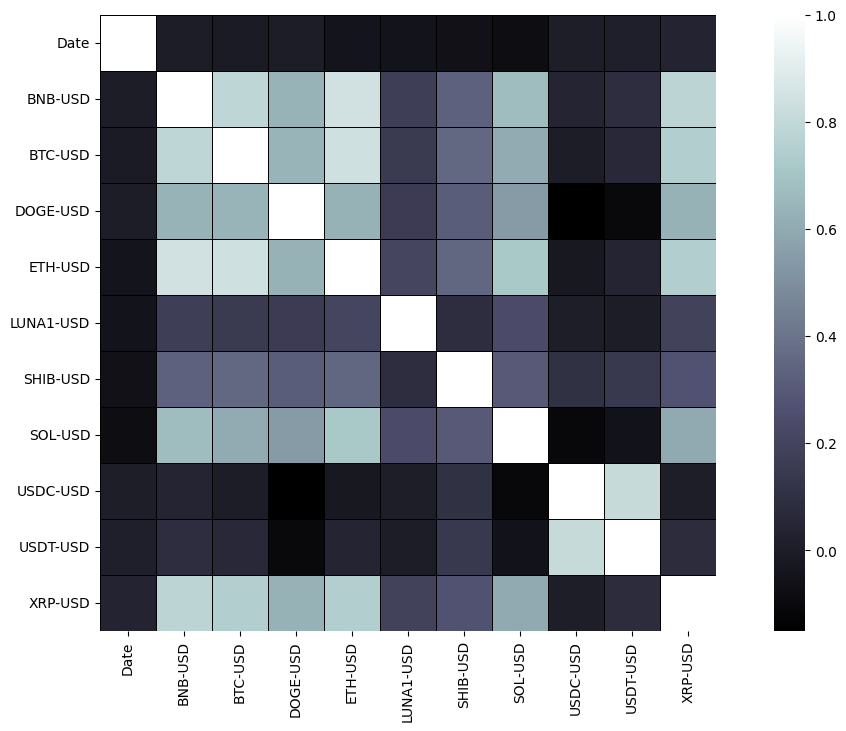

In [57]:
plt.figure(figsize = (15,8))
sns.heatmap(log_returns.corr(), cmap = "bone", linewidths = .7, linecolor = "black", square = True)
log_returns.corr()

Below are the results of the Engle Granger cointegration tests on the returns series.

In [58]:
dfReturns = cryptoDF.iloc[: , 1:]
for a1 in dfReturns.columns:
    for a2 in dfReturns.columns:
        if a1 != a2:
            test_result = ts.coint(dfReturns[a1], dfReturns[a2])
            print(a1 + ' and ' + a2 + ': p-value = ' + str(test_result[1]))

BNB-USD and BTC-USD: p-value = 0.5391191445586864
BNB-USD and DOGE-USD: p-value = 0.2508408688307513
BNB-USD and ETH-USD: p-value = 0.10839070660919142
BNB-USD and LUNA1-USD: p-value = 0.39447904687758995
BNB-USD and SHIB-USD: p-value = 0.31934515253642926
BNB-USD and SOL-USD: p-value = 0.34634339166151984
BNB-USD and USDC-USD: p-value = 0.7241995517864763
BNB-USD and USDT-USD: p-value = 0.5227654919274946
BNB-USD and XRP-USD: p-value = 0.5490611383324627
BTC-USD and BNB-USD: p-value = 0.6809034748458278
BTC-USD and DOGE-USD: p-value = 0.2397161987155353
BTC-USD and ETH-USD: p-value = 0.6296403092309995
BTC-USD and LUNA1-USD: p-value = 0.5692985621841236
BTC-USD and SHIB-USD: p-value = 0.7809178893301347
BTC-USD and SOL-USD: p-value = 0.6893663038156653
BTC-USD and USDC-USD: p-value = 0.6296576762397721
BTC-USD and USDT-USD: p-value = 0.6196274036421857
BTC-USD and XRP-USD: p-value = 0.1767633081616864
DOGE-USD and BNB-USD: p-value = 0.13485298695067516
DOGE-USD and BTC-USD: p-value = 

Below are the results of the Engle Granger cointegration tests on the log return series.

In [59]:
df_log = log_returns.iloc[: , 1:]
for a1 in df_log.columns:
    for a2 in df_log.columns:
        if a1 != a2:
            test_result = ts.coint(df_log[a1], df_log[a2])
            print(a1 + ' and ' + a2 + ': p-value = ' + str(test_result[1]))

BNB-USD and BTC-USD: p-value = 1.8979119791313816e-21
BNB-USD and DOGE-USD: p-value = 8.92258660903436e-16
BNB-USD and ETH-USD: p-value = 6.498811136590814e-13
BNB-USD and LUNA1-USD: p-value = 3.2015671465325856e-10
BNB-USD and SHIB-USD: p-value = 1.8166316879782046e-09
BNB-USD and SOL-USD: p-value = 2.456996364460762e-15
BNB-USD and USDC-USD: p-value = 6.840455308139882e-10
BNB-USD and USDT-USD: p-value = 7.801335027017597e-10
BNB-USD and XRP-USD: p-value = 1.0047942461908508e-17
BTC-USD and BNB-USD: p-value = 0.0
BTC-USD and DOGE-USD: p-value = 0.0
BTC-USD and ETH-USD: p-value = 0.0
BTC-USD and LUNA1-USD: p-value = 0.0
BTC-USD and SHIB-USD: p-value = 2.14395904354501e-09
BTC-USD and SOL-USD: p-value = 6.015283646678337e-28
BTC-USD and USDC-USD: p-value = 0.0
BTC-USD and USDT-USD: p-value = 0.0
BTC-USD and XRP-USD: p-value = 0.0
DOGE-USD and BNB-USD: p-value = 1.694293022144966e-21
DOGE-USD and BTC-USD: p-value = 9.886420429819603e-18
DOGE-USD and ETH-USD: p-value = 2.5838395101947516

Based on the results of the correlation tests and cointegration tests Bitcoin and Ethereum are identified as a potential pair of assests to implement the pairs trading strategy on. The next steps to plot the spread between the two cryptocurrencies and add lines to indicate to a trader when the spread between the pair of cryptocurrencies has significantly diverged from its long run mean. 

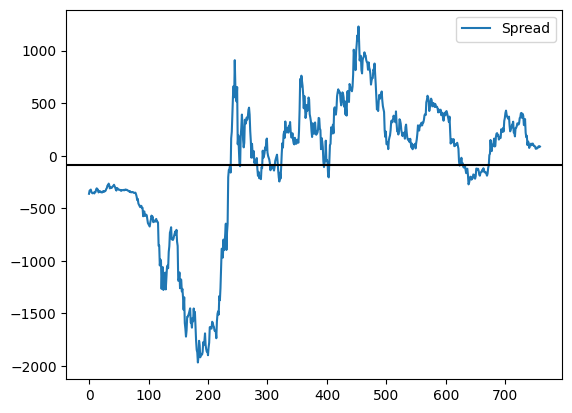

In [60]:
# plots the spread on the return series data
A1 = dfReturns["BTC-USD"]
A2 = dfReturns["ETH-USD"]
A1 = sm.add_constant(A1)
results = sm.OLS(A2, A1).fit()
A1 = A1["BTC-USD"]
b = results.params["BTC-USD"]

spread = A2 - b * A1
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

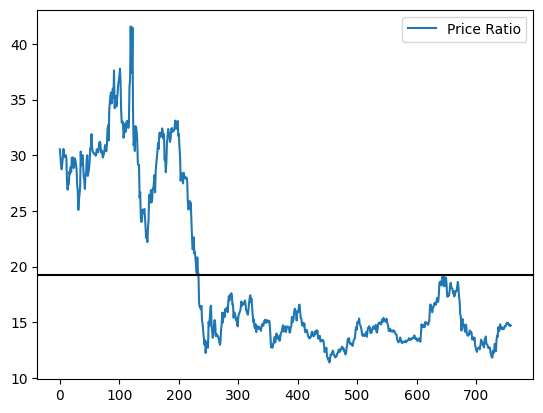

In [61]:
# plots the price ratio on the returns series
ratio = A1/A2
ratio.plot()
plt.axhline(ratio.mean(), color='black')
plt.legend(['Price Ratio']);

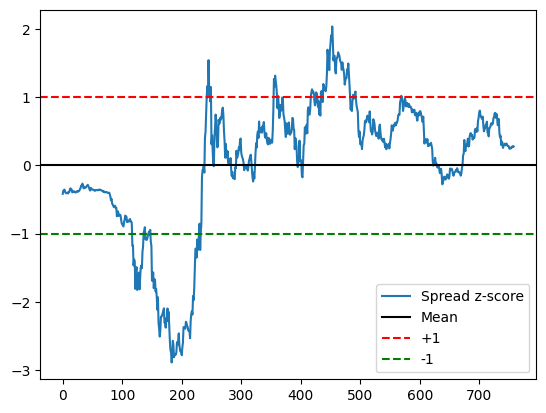

In [62]:
# plots the spread of Bitcoin and Ethereum using the return series data and includes indicators 
# to aleart traders when potential buying opertunities arise.
def zscore(series):
    return (series - series.mean()) / np.std(series)
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

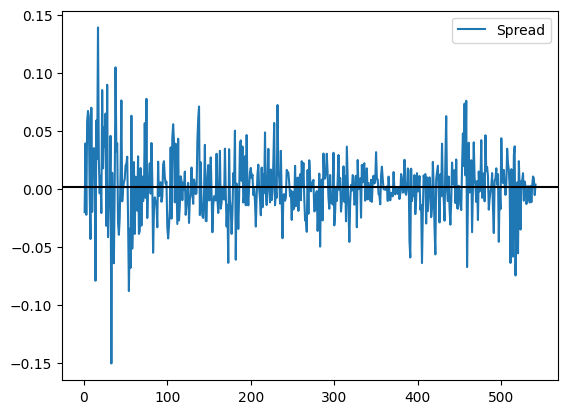

In [63]:
# plots the spread on the log return series data
A1 = df_log["BTC-USD"]
A2 = df_log["ETH-USD"]
A1 = sm.add_constant(A1)
results = sm.OLS(A2, A1).fit()
A1 = A1["BTC-USD"]
b = results.params["BTC-USD"]

spread = A2 - b * A1
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

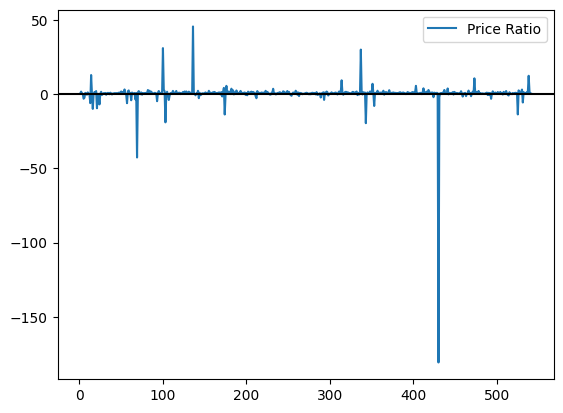

In [64]:
# plots the price ratio on the log returns series
ratio = A1/A2
ratio.plot()
plt.axhline(ratio.mean(), color='black')
plt.legend(['Price Ratio']);

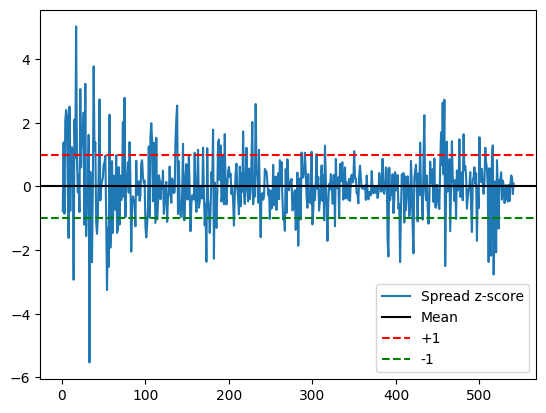

In [65]:
# plots the spread of Bitcoin and Ethereum using the log return series data and includes indicators 
# to aleart traders when potential buying opertunities arise.
def zscore(series):
    return (series - series.mean()) / np.std(series)
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

### Trading Strategy Revised
1. Short the spread when the z-score is above 1 (i.e. buy one share of A2 short sell one share of A1)
2. Long the spread when the z-score is below -1 (i.e. buy one share of A1 short sell one share of A2)